In [1]:
import uproot
import awkward as ak

import matplotlib.pylab as plt
import numpy as np

import hist
from hist import Hist

import time

import seaborn as sns
import pandas as pd

# References

## BaBar

https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Find_Data

https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Physics

https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Physics/skims

https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Available_Data

https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Available_Lists#Composite_Particle_Lists

https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Lambda_Lists

## Physics

https://pdglive.lbl.gov/Viewer.action

https://pdglive.lbl.gov/ParticleGroup.action?init=0&node=BXXX020

https://pdglive.lbl.gov/Particle.action?init=0&node=S033&home=BXXX040

https://pdglive.lbl.gov/ParticleGroup.action?init=0&node=MXXX045



## Code

### Uproot
https://uproot.readthedocs.io/en/latest/basic.html

### Awkward arrays
https://awkward-array.org/doc/main/

https://awkward-array.org/doc/main/getting-started/index.html (see left-hand navigation bar with different tutorials)

### Histogram

https://hist.readthedocs.io/en/latest/




# Open the file and extract the data

Using straight `uproot` and some of the "original" BaBar files

*Note! This is not the approach we will use for the full analysis, but it is useful for you to see how to do this with the ROOT files, in case you need to do some preliminary checks that I missed.*

In [2]:
topdir = '/mnt/qnap/babar_data/bnv_plambda'

filename = f'{topdir}/SP-1005-LambdaVeryVeryLoose-Run3-R24a2-v03_COMBINED.root'

f = uproot.open(filename)

print(f.keys())

# This extracts the ROOT ntuple (TTree)
# From this we can extract awkward arrays
t = f['ntp1']

print(type(t))

['ntp1;1']
<class 'uproot.models.TTree.Model_TTree_v20'>


In [3]:
# Display the variable names

keys = t.keys()

keys

['runNumber',
 'platform',
 'partition',
 'upperID',
 'lowerID',
 'majorID',
 'configKey',
 'date',
 'ddate',
 'eePx',
 'eePy',
 'eePz',
 'eeE',
 'beamSX',
 'beamSY',
 'beamSZ',
 'beamSCovXX',
 'beamSCovYY',
 'beamSCovZZ',
 'beamSCovXZ',
 'nTracks',
 'nGoodTrkLoose',
 'nChargedTracks',
 'R2',
 'R2All',
 'thrustMag',
 'thrustMagAll',
 'thrustCosTh',
 'thrustCosThAll',
 'thrustPhi',
 'thrustPhiAll',
 'sphericityAll',
 'mcLen',
 'mcLund',
 'mothIdx',
 'dauLen',
 'dauIdx',
 'mcmass',
 'mcp3CM',
 'mccosthCM',
 'mcphiCM',
 'mcenergyCM',
 'mcp3',
 'mccosth',
 'mcphi',
 'mcenergy',
 'mcVtxx',
 'mcVtxy',
 'mcVtxz',
 'nB',
 'BChi2',
 'BCosSphr',
 'BCosThetaS',
 'BCosThetaT',
 'BCosThrust',
 'BLegendreP0',
 'BLegendreP2',
 'BMass',
 'BMassErr',
 'BPFlow0',
 'BPFlow1',
 'BPFlow2',
 'BPFlow3',
 'BPFlow4',
 'BPFlow5',
 'BPFlow6',
 'BPFlow7',
 'BPFlow8',
 'BR2ROE',
 'BSphr',
 'BSphrROE',
 'BThrust',
 'BThrustROE',
 'BVtxx',
 'BVtxy',
 'BVtxz',
 'B_con_Chi2',
 'B_con_Mass',
 'B_con_MassErr',
 'B_con_V

Print out the variables in the TTree/awkward array in a neater way. 

In [4]:
keys = t.keys()

max_len = 80
output = ""
for k in keys:
    if len(output)<max_len:
        output = f"{output}{k:20s} "
    else:
        print(output)
        output = f"{k:20s} "

runNumber            platform             partition            upperID              
lowerID              majorID              configKey            date                 
ddate                eePx                 eePy                 eePz                 
eeE                  beamSX               beamSY               beamSZ               
beamSCovXX           beamSCovYY           beamSCovZZ           beamSCovXZ           
nTracks              nGoodTrkLoose        nChargedTracks       R2                   
R2All                thrustMag            thrustMagAll         thrustCosTh          
thrustCosThAll       thrustPhi            thrustPhiAll         sphericityAll        
mcLen                mcLund               mothIdx              dauLen               
dauIdx               mcmass               mcp3CM               mccosthCM            
mcphiCM              mcenergyCM           mcp3                 mccosth              
mcphi                mcenergy             mcVtxx               mc

# Exploring the data

In [5]:
# You can access the values in an TTree array as follow
# Note that in each case, we need the .array at the end to actually get the values. 

# Get the proton energy. 
x = t['penergy'].array()

print(x)

# Get the number of protons in each event using an awkward function

n = ak.num(x)

print(n)

[[3.62, 1.88], [4.12, 1.95], [2.97, 2.82], ..., [1.95, 3.24], [2.18, 3.57]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..., 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [6]:
t["nTRK"].array()

<Array [7, 9, 7, 7, 7, 7, 8, 9, ..., 6, 7, 6, 11, 7, 9, 6] type='25588 * int32'>

# Interfacing with the files we will use for analysis

These files have already been processed and only the awkward arrays have been stored. 

These files are [parquet files](https://www.databricks.com/glossary/what-is-parquet).

In [7]:
# Background
filename = f'{topdir}/Background_SP_modes_Only_Run_1.parquet'

# Signal
#filename = f'{topdir}/Signal_SP_mode.parquet'

start = time.time()

data = ak.from_parquet(filename)

print(f"Took {time.time() - start} s")

print(type(data))

Took 0.6072337627410889 s
<class 'awkward.highlevel.Array'>


We can print out the variable names in the same way, but we use the `fields` data member. 

In [8]:
keys = data.fields

max_len = 80
output = ""
for k in keys:
    if len(output)<max_len:
        output = f"{output}{k:20s} "
    else:
        print(output)
        output = f"{k:20s} "
print(output)

runNumber            platform             partition            upperID              
lowerID              majorID              configKey            date                 
ddate                eePx                 eePy                 eePz                 
eeE                  beamSX               beamSY               beamSZ               
beamSCovXX           beamSCovYY           beamSCovZZ           beamSCovXZ           
nTracks              nGoodTrkLoose        nChargedTracks       R2                   
R2All                thrustMag            thrustMagAll         thrustCosTh          
thrustCosThAll       thrustPhi            thrustPhiAll         sphericityAll        
mcLen                mcLund               mothIdx              dauLen               
dauIdx               mcmass               mcp3CM               mccosthCM            
mcphiCM              mcenergyCM           mcp3                 mccosth              
mcphi                mcenergy             mcVtxx               mc

We can access the values now without the `.values()` at the end. 

In [9]:
data['penergy']

<Array [[4.15, 1.65], [...], ..., [4.33, 1.55]] type='41962 * var * float32'>

In [10]:
# Or like this

data.penergy

<Array [[4.15, 1.65], [...], ..., [4.33, 1.55]] type='41962 * var * float32'>

## Some other examples

<Array [4.15, 1.65, 1.45, 4.41, ..., 2.88, 4.33, 1.55] type='84351 * float32'>

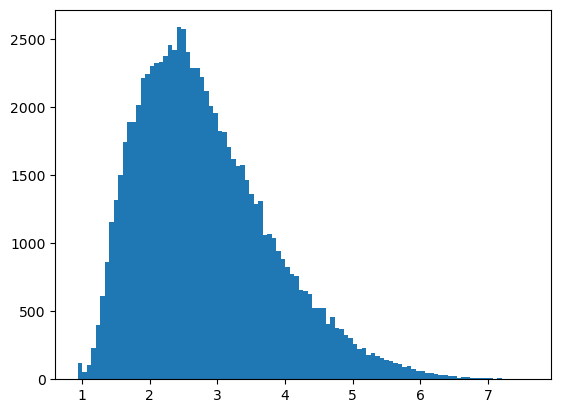

In [11]:
x = data['penergy']

# Need to flatten it before we plot, if it is multidimensional

x = ak.flatten(x)

plt.hist(x,bins=100);
x

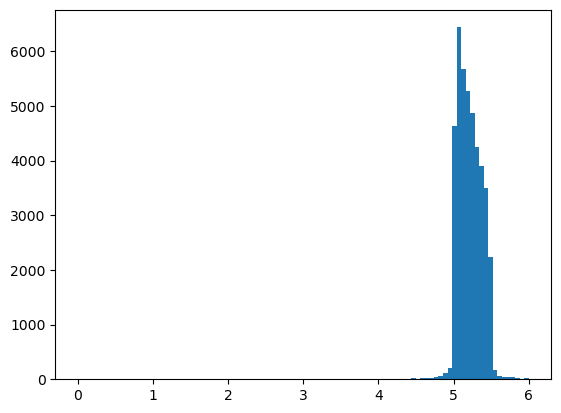

In [12]:
# Plot only the first instance in each event

x = data['BMass'][:,0]

# This is only 1-dimensional so we don't need to flatten it. 
plt.hist(x,bins=100, range=(0,6));

## Histogram

In [13]:
# Get all the SP modes

x = data['spmode']

spmodes = np.unique(x.to_list())

print(spmodes)

['1005' '1235' '1237' '3981' '991' '998']


In [14]:
# Create a histogram
h = Hist.new.Reg(100, 5.2, 5.3, name="BpostFitMes", label=r"M$_{ES}$ [GeV/c$^2$]") \
         .StrCat([], name="SP", label="SP modes", growth=True)\
         .StrCat([], name="cuts", label="Cuts", growth=True)\
         .Weight()

# Fill the histogram
for spmode in spmodes:
    sp_mask = data.spmode == spmode
    x = data[sp_mask]['BpostFitMes'][:,0]
    h.fill(BpostFitMes=x, SP=spmode, cuts=f"0", weight=1)

Display it in different ways

In [15]:
#h[:,"998","0"].plot(histtype="fill", linewidth=1, edgecolor="grey")
#h[:,"-999","0"].plot(histtype="fill", linewidth=1, edgecolor="grey")

In [16]:
#h[:,"1235","0"].plot(histtype="fill", linewidth=1, edgecolor="grey")

In [17]:
#h.stack('SP')[:].project('BpostFitMes').plot(stack=True, histtype="fill")

#plt.legend()

Now for  the other thing!

In [18]:
# Create the histogram, this does not fill it in

j= Hist.new.Reg(100, -1,1, name= "BpostFitDeltaE", label= r"idk yet [GeV]?") \
        .StrCat([],name= "SP", label= "sp modes", growth= True)\
        .StrCat([], name= "cuts", label= "Cuts", growth= True)\
        .Weight()

# Fill 

for spmode in spmodes: 
    sp_mask2= data.spmode== spmode
    y= data[sp_mask2]["BpostFitDeltaE"][:,0]
    j.fill(BpostFitDeltaE=y, SP= spmode, cuts= f"0", weight=1)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9b11bc8e50>, errorbar=None, legend_artist=None)]

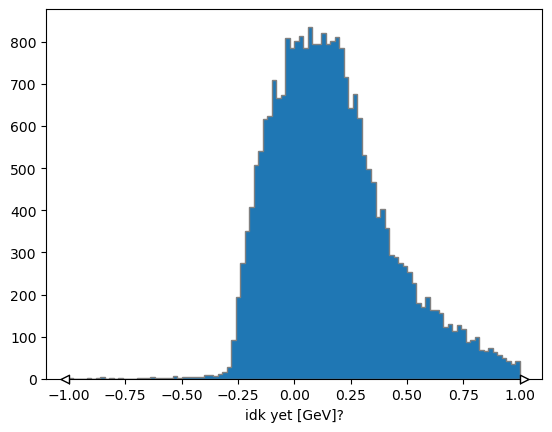

In [19]:
#j[:,"998","0"].plot(histtype="fill", linewidth=1, edgecolor="grey")
j[:,"998","0"].plot(histtype="fill", linewidth=1, edgecolor="grey")

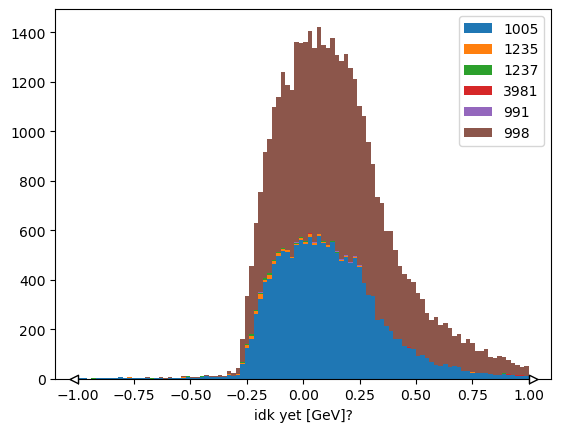

In [20]:
j.stack('SP')[:].project('BpostFitDeltaE').plot(stack=True, histtype="fill")

plt.legend()

## Lambda 


Matplotlib histogram:

In [21]:
Lambda_mass= data.Lambda0_unc_Mass
Flight_length= data.Lambda0FlightLen

flat_Lambda_mass= ak.flatten(Lambda_mass)

Flight_length

<Array [[2.58, -1e+06], [...], ..., [-1e+06]] type='41962 * var * float32'>

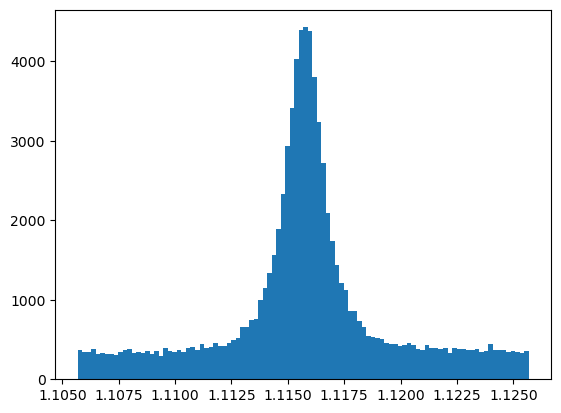

In [22]:
plt.hist(flat_Lambda_mass, bins= 100);

hist class:

In [23]:
h_lambda_FL= Hist.new.Reg(100, -.25,10, name= "Lambda0FlightLen", label= r"flight length [cm]") \
        .StrCat([],name= "SP", label= "sp modes", growth= True)\
        .StrCat([], name= "cuts", label= "Cuts", growth= True)\
        .Weight()

h_lambda_mass= Hist.new.Reg(100,1.105, 1.126, name= "Lambda0_unc_Mass", label= r"Mass GeV") \
        .StrCat([],name= "SP", label= "sp modes", growth= True)\
        .StrCat([], name= "cuts", label= "Cuts", growth= True)\
        .Weight()




for spmode in spmodes: 
    modes= data.spmode== spmode
    x0 = data[modes]["Lambda0FlightLen"][:,0]
    x1 = data[modes]["Lambda0_unc_Mass"][:,0]

    cut_name = "org"
    h_lambda_FL.fill(Lambda0FlightLen=x0,   SP= spmode, cuts= cut_name, weight=1)
    h_lambda_mass.fill(Lambda0_unc_Mass=x1, SP= spmode, cuts= cut_name, weight=1)

    # First cut
    cut_name = "fl_gt_val"
    flight_length_cutter = data[modes]["Lambda0FlightLen"][:,0] > 2.0

    h_lambda_FL.fill(Lambda0FlightLen=x0[flight_length_cutter],   SP= spmode, cuts= cut_name, weight=1)
    h_lambda_mass.fill(Lambda0_unc_Mass=x1[flight_length_cutter], SP= spmode, cuts= cut_name, weight=1)


In [24]:
#h_lambda_FL[:,"998","org"].plot(histtype="fill", linewidth=1, edgecolor="grey")
#h_lambda_FL[:,"998","fl_gt_val"].plot(histtype="fill", linewidth=1, edgecolor="grey")

In [25]:
h_lambda_FL[:,:,'org'].stack('SP').project('Lambda0FlightLen')

Stack<('1005', '1235', '1237', '3981', '991', '998') of Hist(Regular(100, -0.25, 10, name='Lambda0FlightLen', label='flight length [cm]'), storage=Weight()) # Sum: WeightedSum(value=11408, variance=11408) (WeightedSum(value=15863, variance=15863) with flow)>

In [26]:
#h_lambda_FL.show()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9b11c83990>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9b1333b910>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9b11b5a050>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9b11ada650>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9b13293210>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9b133f1810>, errorbar=None, legend_artist=None)]

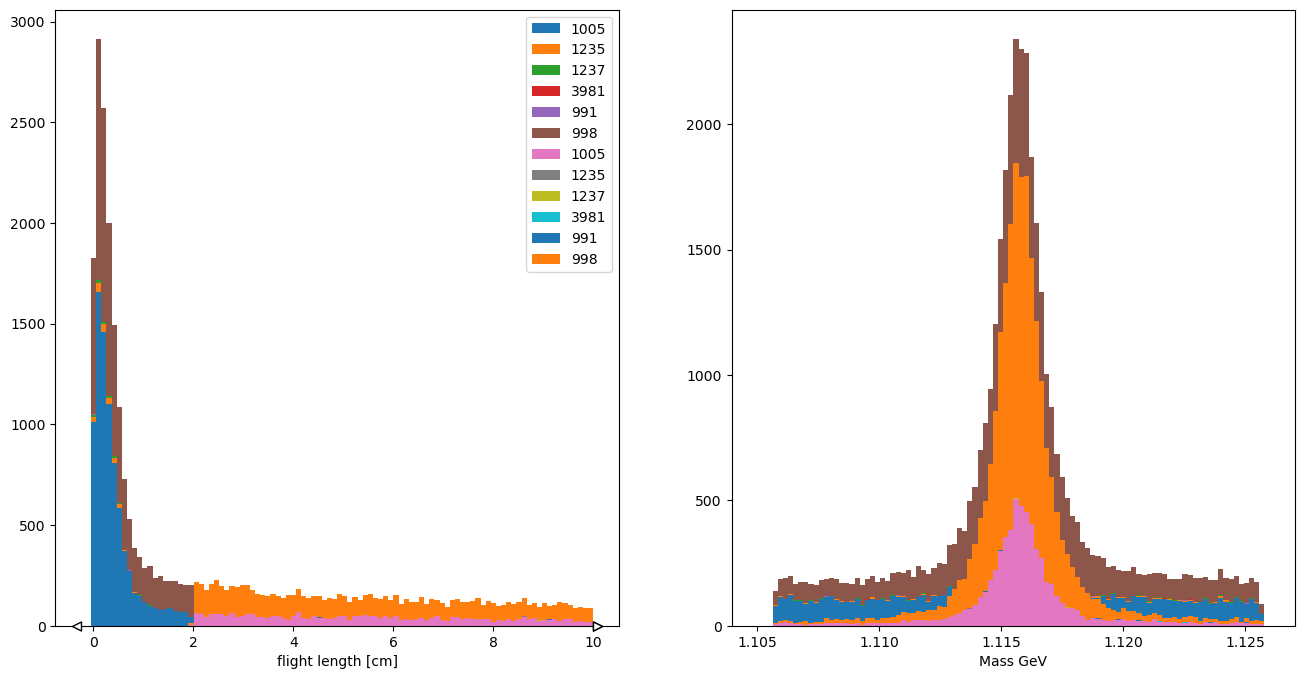

In [27]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
h_lambda_FL[:,:,'org'].stack('SP')[:].project('Lambda0FlightLen').plot(stack=True, histtype="fill")
h_lambda_FL[:,:,'fl_gt_val'].stack('SP')[:].project('Lambda0FlightLen').plot(stack=True, histtype="fill")

plt.legend()

plt.subplot(1,2,2)
h_lambda_mass[:,:,'org'].stack('SP')[:].project('Lambda0_unc_Mass').plot(stack=True, histtype="fill")
h_lambda_mass[:,:,'fl_gt_val'].stack('SP')[:].project('Lambda0_unc_Mass').plot(stack=True, histtype="fill")



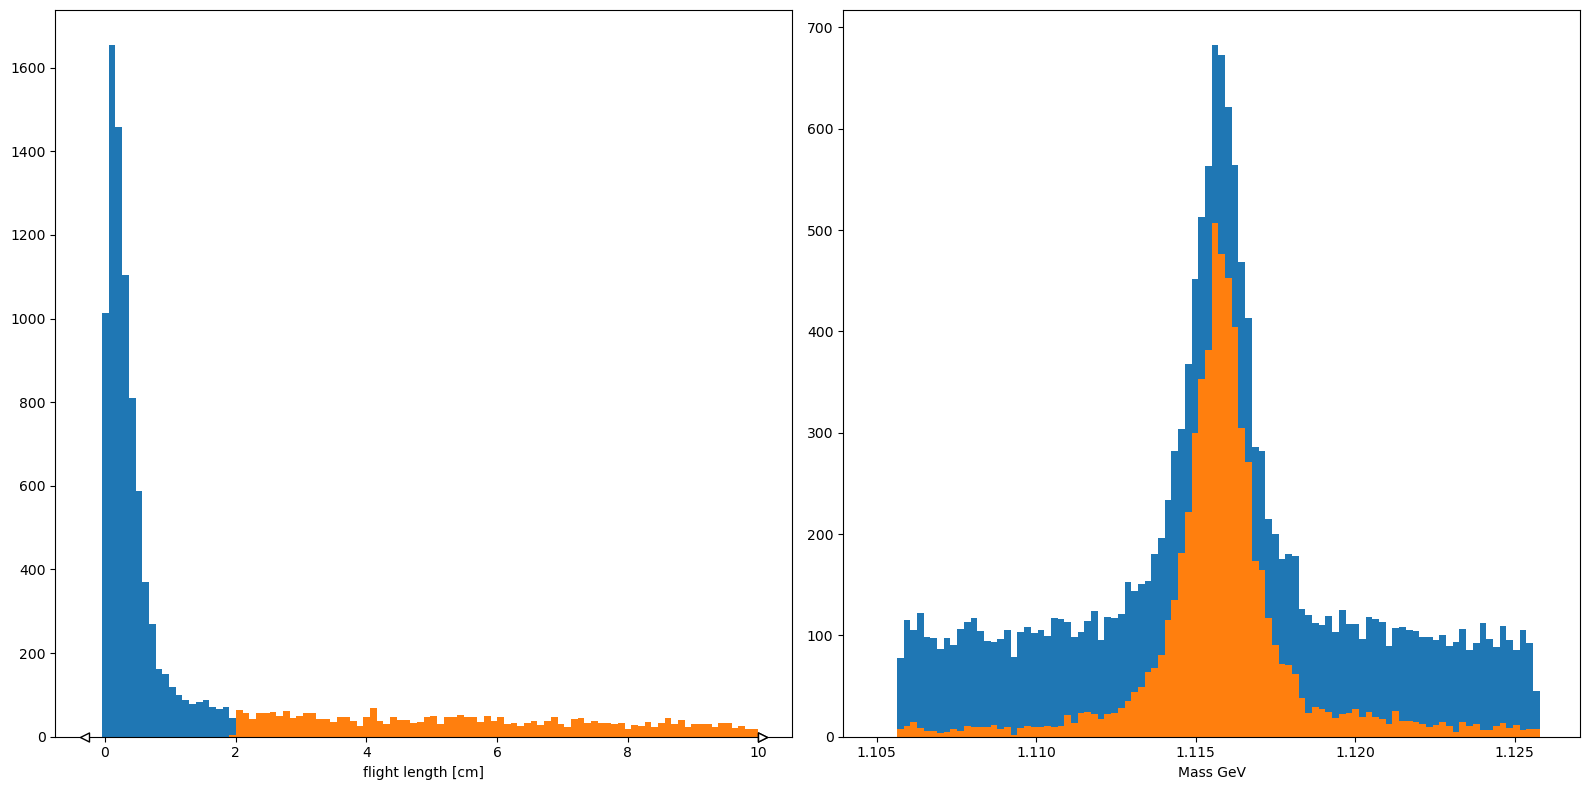

In [28]:
plt.figure(figsize=(16,8))

sp = '1005'

plt.subplot(1,2,1)
h_lambda_FL[:,sp,'org'].project('Lambda0FlightLen').plot(histtype="fill")
h_lambda_FL[:,sp,'fl_gt_val'].project('Lambda0FlightLen').plot(histtype="fill")

#plt.legend()

plt.subplot(1,2,2)
h_lambda_mass[:,sp,'org'].project('Lambda0_unc_Mass').plot(histtype="fill")
h_lambda_mass[:,sp,'fl_gt_val'].project('Lambda0_unc_Mass').plot(histtype="fill")

plt.tight_layout()

In [29]:
h_lambda_FL[:,:,'org']

Hist(
  Regular(100, -0.25, 10, name='Lambda0FlightLen', label='flight length [cm]'),
  StrCategory(['1005', '1235', '1237', '3981', '991', '998'], growth=True, name='SP', label='sp modes'),
  storage=Weight()) # Sum: WeightedSum(value=26970, variance=26970) (WeightedSum(value=41962, variance=41962) with flow)

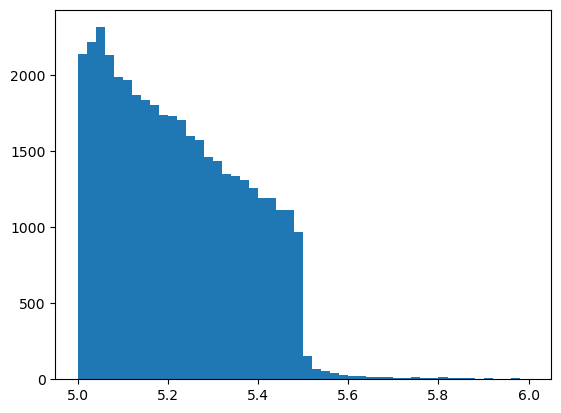

In [30]:
x= data["BMass"][:,0]

plt.hist(x, bins=50, range=(5,6));

# Next steps

* Plot `BpostFitMes` and `BpostFitDeltaE`
* Do individual histograms
* Do a 2D histogram (try with `Hist`)

Bellis will get you a signal file so you can see how the signal looks different from all of these. 

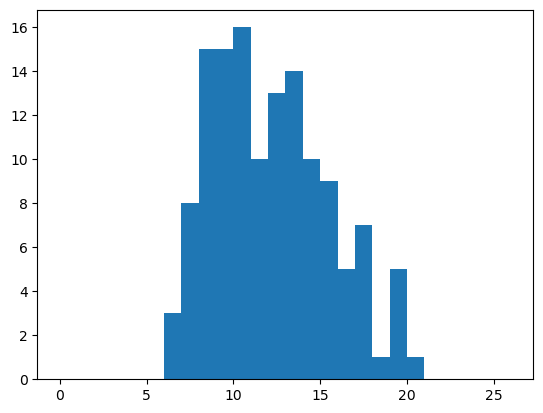

In [31]:
x = data['nTRK']

SP_1237 = data['spmode'] == '1237'

plt.hist(x[SP_1237],bins=26,range=(0,26));

In [32]:
data['spmode'];

Text(0.5, 0, 'E [GeV]')

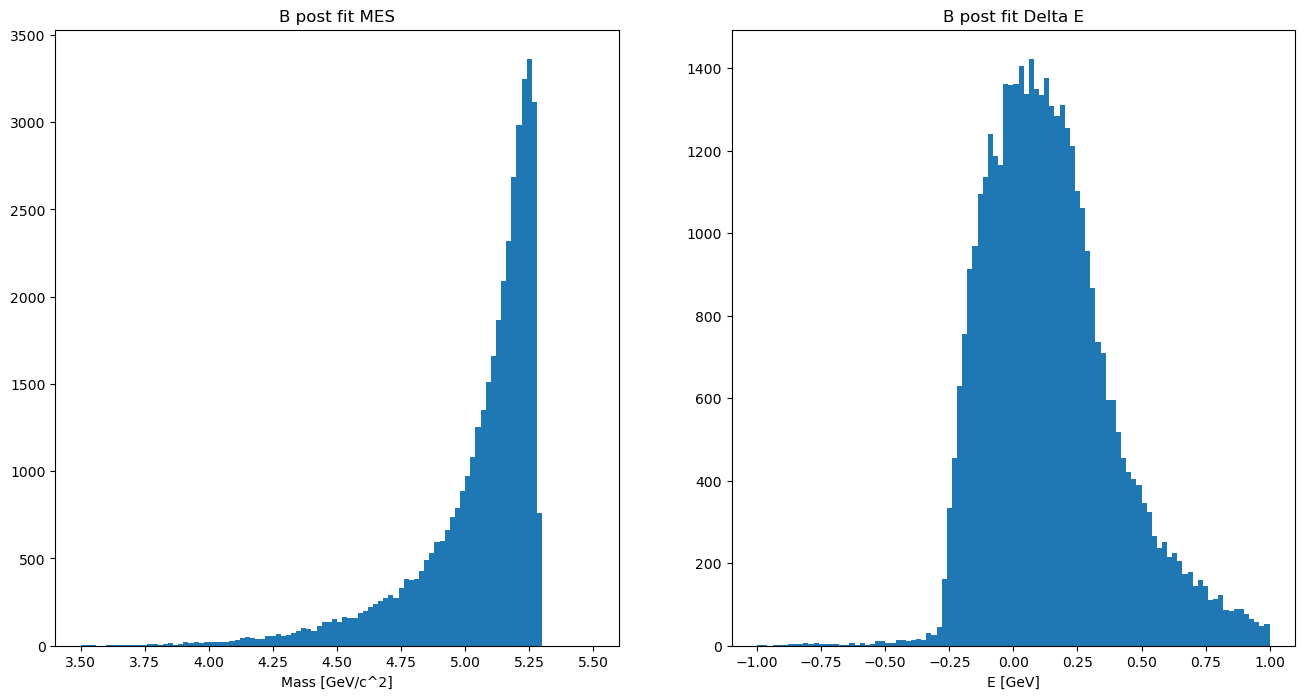

In [33]:
BPFM= data["BpostFitMes"][:,0]
BPFDE= data["BpostFitDeltaE"][:,0]

plt.figure(figsize= (16,8))

plt.subplot(1,2,1)
plt.title("B post fit MES")
plt.hist(BPFM, bins= 100, range= (3.5,5.5));
plt.xlabel("Mass [GeV/c^2]")

plt.subplot(1,2,2)
plt.title("B post fit Delta E")
plt.hist(BPFDE, bins= 100, range=(-1,1));
plt.xlabel("E [GeV]")

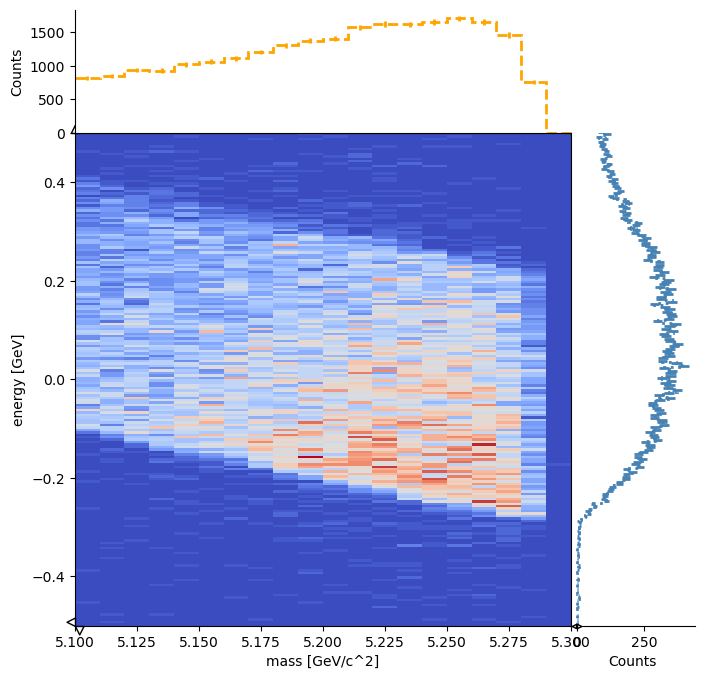

In [34]:
plt.figure(figsize=(8, 8))

h= Hist(
    hist.axis.Regular(400,3,7,name= "BPFM", label= "mass [GeV/c^2]", flow= True),
    hist.axis.Regular(350,-.75,1,name= "BPFMDE", label= "energy [GeV]", flow= True),
)

# normal fill
h.fill(BPFM, BPFDE)

h.plot2d_full(
    main_cmap="coolwarm",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)

plt.xlim(5.1,5.3)
plt.ylim(-.5,.5)
plt.show()

In [35]:
events_in_range= sum(5.2<x<5.3 for x in BPFM) & sum(-.2<x<.2 for x in BPFDE)

total_frac= events_in_range/len(BPFM)

In [36]:
type(data)

awkward.highlevel.Array

In [37]:
BPFM

<Array [5.25, 4.83, 5.01, 4.96, ..., 5.27, 5.25, 5.21] type='41962 * float32'>

(-0.5, 0.5)

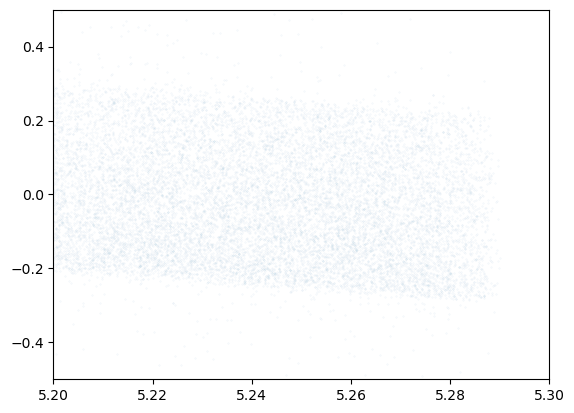

In [39]:
plt.plot(BPFM, BPFDE, '.', markersize=0.5, alpha=0.1)
plt.xlim(5.2, 5.3)
plt.ylim(-0.5, 0.5)

Note that the mass shows a steady drop off (as is characteristic of using MES) and that the change in energy is symmetric about zero. 

The symmetricity about zero arises from the calculation of $\Delta E$= $E_{e^+e^-}-E_B$. Since $E_{e^+e^-}$ is an unchanging value and the mass of the B candidate should be close to that number. 

The drop off in the mass is a result of the same idea. For better resolution on the B mass, you can relate the momentum of the B to the energy of the beam, since the main particles produced in electron positron collisions at this energy are a B and an anti B. So, half of the energy of the beam goes into creating one B, and the other half goes into creating the B bar. The mass is calculated by the following: 

$M^2 = (E_p+E_\Lambda)^2-(p_p+p_\Lambda)^2$

where the $(E_p+E_\Lambda)$ is the energy of the B (given by the addition of its primary decay constituents) and the $(p_p+p_\Lambda)$ is the same but with the momentum instead of the energy. $(E_p+E_\Lambda)$ can be approximated as $\frac{1}{2}E_{e^+e^-}$!

## Scaling and cross section data

In [40]:
import pandas as pd

In [41]:
dataset_information = pd.read_csv("BaBar_analyses_BNV_pLambda_data_for_scaling.csv")
cs_data= pd.read_csv("BaBar_analyses_BNV_pLambda_cross_section_data.csv")

In [42]:
dataset_information

,Data or MC,SP mode,Run,Skim,# of events (Data or MC),# of events (Data or MC) NOT SURE WHICH NUMBER TO USE,Luminosity (Data only) 1/pb,# of collections/files (Data or MC),Missing collections?
0,Data,-1,1,NaN,292554209,928849927,20782.9,3306,1
1,Data,-1,2,NaN,958854016,2255075947,61643.1,5214,0
2,Data,-1,3,NaN,501277316,1160966741,32530.3,3678,0
3,Data,-1,4,NaN,1590601212,3748112198,101454.8,6667,10
4,Data,-1,5,NaN,2104338820,4982538289,134908.1,8057,0
...,...,...,...,...,...,...,...,...,...
103,MC,991,2,LambdaVeryVeryLoose,0,0,0.0,0,0
104,MC,991,3,LambdaVeryVeryLoose,0,0,0.0,0,0
105,MC,991,4,LambdaVeryVeryLoose,0,0,0.0,0,0
106,MC,991,5,LambdaVeryVeryLoose,0,0,0.0,0,0


In [43]:
Data_and_Skim_mask = (dataset_information['Data or MC'] == 'Data') & (dataset_information['Skim'] != 'LambdaVeryVeryLoose')
dataset_information[Data_and_Skim_mask]

,Data or MC,SP mode,Run,Skim,# of events (Data or MC),# of events (Data or MC) NOT SURE WHICH NUMBER TO USE,Luminosity (Data only) 1/pb,# of collections/files (Data or MC),Missing collections?
0,Data,-1,1,NaN,292554209,928849927,20782.9,3306,1
1,Data,-1,2,NaN,958854016,2255075947,61643.1,5214,0
2,Data,-1,3,NaN,501277316,1160966741,32530.3,3678,0
3,Data,-1,4,NaN,1590601212,3748112198,101454.8,6667,10
4,Data,-1,5,NaN,2104338820,4982538289,134908.1,8057,0
5,Data,-1,6,NaN,1262797446,3017207678,79553.1,4115,0


In [44]:
nevents = dataset_information[Data_and_Skim_mask]['# of events (Data or MC)'].sum()
nevents

6710423019

In [45]:
nevents_other = dataset_information[Data_and_Skim_mask]['# of events (Data or MC) NOT SURE WHICH NUMBER TO USE'].sum()
nevents_other

16092750780

In [46]:
int_lumi = dataset_information[Data_and_Skim_mask]['Luminosity (Data only) 1/pb'].sum()
int_lumi

430872.30000000005

In [47]:
cs_data

,SP Mode,Human-readable explamanation,LaTeX output,Cross section [nb],Uncertainty,"Note: cross sections found at https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Physics/Cross_sections,_luminosities,_and_other_vital_stats"
0,1235,B+B- pairs,B^+ B^-,0.525,0.000,Cross section number is out of date
1,1237,B0 B0bar pairs,B^0\bar{B^0},0.525,0.000,NaN
2,1005,ccbar,c\bar{c},1.300,0.000,NaN
3,998,uubar/ddbar/ssbar,"u\bar{u}, d\bar{d}, c\bar{c}",2.090,0.000,NaN
4,2400,bhabha- e+e- to e+e-,e^+e^-,40.000,0.000,NaN
5,3429,tau+tau-,\tau^+\tau^-,0.919,0.003,NaN
6,3981,mu+mu- gamma,\mu^+\mu^-\gamma,1.147,0.005,Cross section value only for mu+mu- pairs


In [48]:
spmodes = np.unique(cs_data['SP Mode'].values)

spmodes = spmodes[spmodes != 2400]

spmodes

array([ 998, 1005, 1235, 1237, 3429, 3981])

In [49]:
SP_not_2400 = cs_data['SP Mode'] != 2400

expected_events = cs_data[SP_not_2400]['Cross section [nb]'] * int_lumi * 1000 # The 1000 is because cs is in nb and lumi is pb^-1

expected_events

0    226207957.5
1    226207957.5
2    560133990.0
3    900523107.0
5    395971643.7
6    494210528.1
Name: Cross section [nb], dtype: float64

In [50]:
tot_expected_events = expected_events.sum()
tot_expected_events

2803255183.8000007

In [51]:
cs_data[SP_not_2400]

,SP Mode,Human-readable explamanation,LaTeX output,Cross section [nb],Uncertainty,"Note: cross sections found at https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Physics/Cross_sections,_luminosities,_and_other_vital_stats"
0,1235,B+B- pairs,B^+ B^-,0.525,0.000,Cross section number is out of date
1,1237,B0 B0bar pairs,B^0\bar{B^0},0.525,0.000,NaN
2,1005,ccbar,c\bar{c},1.300,0.000,NaN
3,998,uubar/ddbar/ssbar,"u\bar{u}, d\bar{d}, c\bar{c}",2.090,0.000,NaN
5,3429,tau+tau-,\tau^+\tau^-,0.919,0.003,NaN
6,3981,mu+mu- gamma,\mu^+\mu^-\gamma,1.147,0.005,Cross section value only for mu+mu- pairs


<class 'pandas.core.frame.DataFrame'>


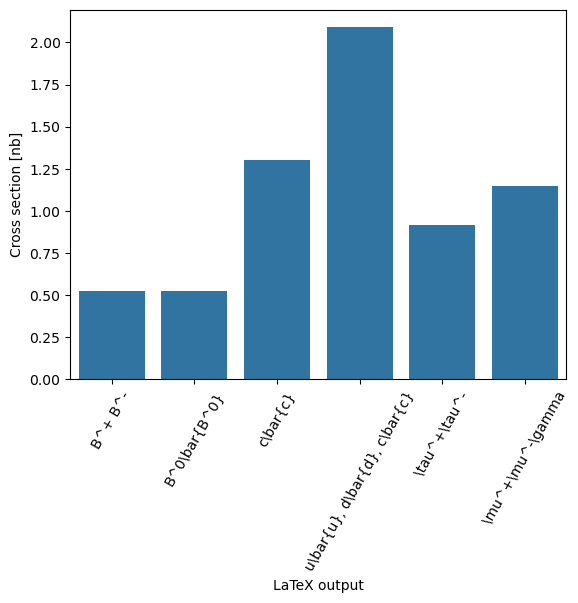

In [52]:
data_wo_SP2400 = cs_data[SP_not_2400]#["Cross section [nb]"]

print(type(data_wo_SP2400))

sns.barplot(data_wo_SP2400, x = 'LaTeX output', y = 'Cross section [nb]')
plt.xticks(rotation=60);

<class 'pandas.core.frame.DataFrame'>


<Axes: xlabel='SP Mode', ylabel='Cross section [nb]'>

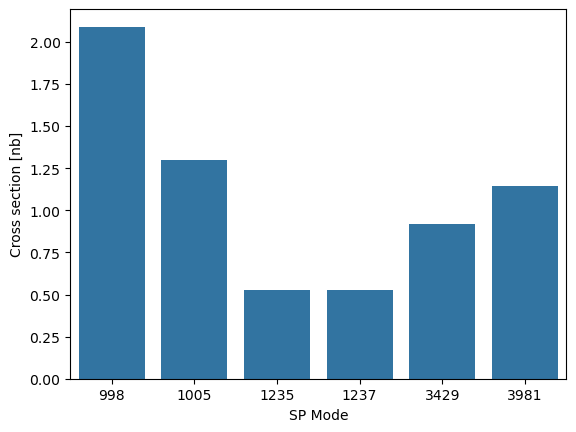

In [53]:
data_wo_SP2400 = cs_data[SP_not_2400]#["Cross section [nb]"]

print(type(data_wo_SP2400))

sns.barplot(data_wo_SP2400, x = 'SP Mode', y = 'Cross section [nb]')

In [54]:
dataset_information.columns

Index(['Data or MC', 'SP mode', 'Run', 'Skim', '# of events (Data or MC)',
       '# of events (Data or MC) NOT SURE WHICH NUMBER TO USE',
       'Luminosity (Data only) 1/pb', '# of collections/files (Data or MC)',
       'Missing collections?'],
      dtype='object')

<Axes: xlabel='Run', ylabel='Luminosity (Data only) 1/pb'>

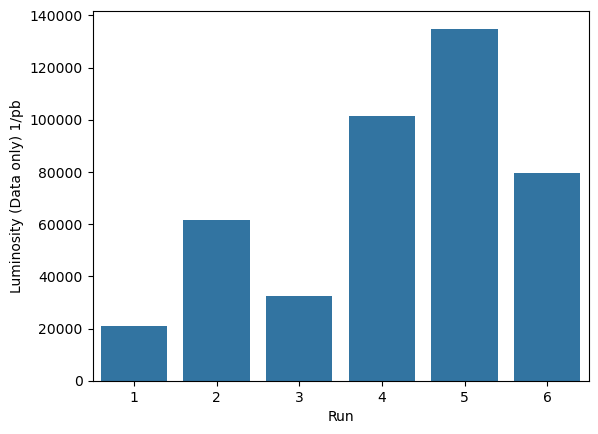

In [55]:
Data_and_Skim_mask = (dataset_information['Data or MC'] == 'Data') & (dataset_information['Skim'] != 'LambdaVeryVeryLoose')


sns.barplot(dataset_information[Data_and_Skim_mask], x = 'Run', y = 'Luminosity (Data only) 1/pb')

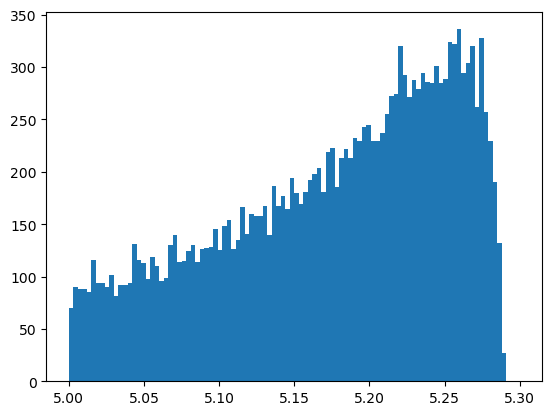

In [56]:
spmask = data['spmode']=='998'

x = data[spmask]['BpostFitMes'][:,0]
x

plt.hist(x,bins=100, range=(5., 5.3));

In [57]:
#len(data[data['spmode'] == '1005'])

In [58]:
dataset_information.columns

Index(['Data or MC', 'SP mode', 'Run', 'Skim', '# of events (Data or MC)',
       '# of events (Data or MC) NOT SURE WHICH NUMBER TO USE',
       'Luminosity (Data only) 1/pb', '# of collections/files (Data or MC)',
       'Missing collections?'],
      dtype='object')

In [59]:
spmode = 1005

SP_and_Skim = (dataset_information['SP mode'] == spmode) & (dataset_information['Skim'] != 'LambdaVeryVeryLoose')

dataset_information[SP_and_Skim]['# of events (Data or MC)']

nevents_mc = dataset_information[SP_and_Skim]['# of events (Data or MC)'].sum()

# Number of SP events of this mode generated for all runs
nevents_mc

1128848000

In [60]:
csmask = cs_data['SP Mode'] == spmode
cs = cs_data[csmask]['Cross section [nb]']

cs = cs.values[0]

# Cross section for this process
print(cs)

number_generated_in_data = cs * int_lumi * 1000
print(number_generated_in_data)

scaling = number_generated_in_data / nevents_mc

print(scaling)

1.3
560133990.0000001
0.49619965664110677


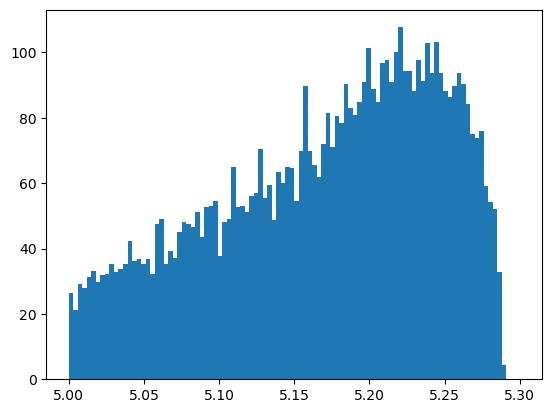

In [61]:
spmask = data['spmode']== str(spmode)

x = data[spmask]['BpostFitMes'][:,0]
x

plt.hist(x,bins=100, range=(5., 5.3), weights=scaling*np.ones(len(x)));

## Scaling Function 

In [62]:
def scaling_value(spmode,plot= False, verbose= False):
    mode= spmode 
    
    mc_mask= (dataset_information["SP mode"]== mode) & (dataset_information["Skim"] != "LambdaVeryVeryLoose")
    # Pulls out all unskimmed MC with desired SP mode
    
    nevents_mc= dataset_information[mc_mask]["# of events (Data or MC)"].sum()
    # Sums the number of unskimmed MC events of the desired SP mode
                
    cs_mask= cs_data["SP Mode"]== mode

    cs= cs_data[cs_mask]["Cross section [nb]"]

    cs= cs.values[0]

    mask = (dataset_information['Data or MC'] == 'Data') & (dataset_information['Skim'] != 'LambdaVeryVeryLoose')
    int_lumi = dataset_information[mask]['Luminosity (Data only) 1/pb'].sum()
    
    n_exp_in_data= cs* int_lumi*1000 
    # Factor of 1000 arises from multiplying nanobarnes by 1/picobarnes
    
    scaling= n_exp_in_data/nevents_mc
    # MC is intentionally overgenerated, so to figure out how to weight the MC, divide the number generated by the total number of MC events

    
    if plot== True:
        spmask = data['spmode']== str(mode)
        x = data[spmask]['BpostFitMes'][:,0]
        plt.hist(x,bins=100, range=(5., 5.3), weights=scaling*np.ones(len(x)));
        plt.title(f"Scaling value for SP-{mode}: {scaling:.4f}")

    if verbose== True: 
        print(f"- Cross section for this SP mode is    {cs} nb")
        print(f"- # of events generated for SP-{mode}: {nevents_mc:13d}")
        print(f"- Number expected in data:             {n_exp_in_data:.1f}")
        print(f"- Integrated Luminosity:               {int_lumi:.1f} 1/pb")
        print("The scaling value for this SP mode is: ")

    return scaling


- Cross section for this SP mode is    2.09 nb
- # of events generated for SP-998:    3592208000
- Number expected in data:             900523107.0
- Integrated Luminosity:               430872.3 1/pb
The scaling value for this SP mode is: 


0.2506879075487834

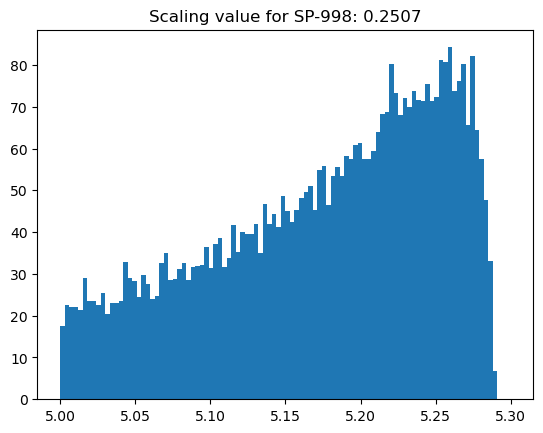

In [63]:
scaling_value(998, plot= True, verbose= True)

In [64]:
#dataset_information

In [65]:
# Integrated Luminosity plot- For each run 

mask1 = (dataset_information['Data or MC'] == 'Data') & (dataset_information["Skim"]!= "LambdaVeryVeryLoose")
unskimmed_data= dataset_information[mask1]


lumis= []
for i in np.arange(0,6):
    luminosity= unskimmed_data["Luminosity (Data only) 1/pb"][i]
    lumis.append(luminosity)

b = [sum(lumis[:i+1]) for i in range(len(lumis))]

xvals= np.arange(1,7)

(0.0, 451376.77)

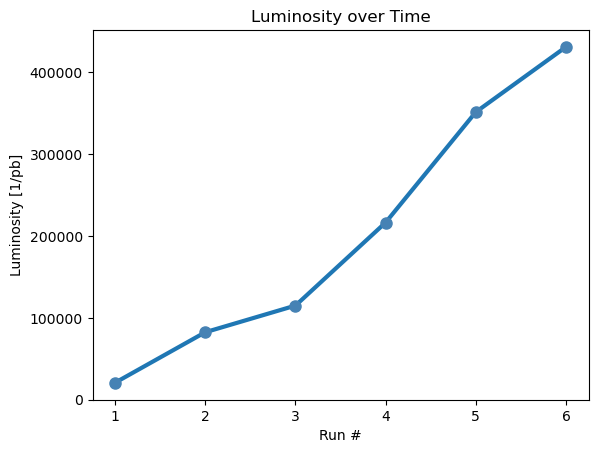

In [66]:
plt.plot(xvals, b,linewidth=3)
plt.plot(xvals, b, "o",color= "steelblue", markersize= 8)
plt.xlabel("Run #")
plt.ylabel("Luminosity [1/pb]")
plt.title("Luminosity over Time")
plt.ylim(0)

## LaTeX

In [68]:
def latex_table_start(fmt):
    output = ""
    output += "\\begin{table}\n"
    output += "\\begin{tabular}{" + f"{fmt}" + "}"

    return output

def latex_table_end(fmt):
    output = ""
    output += "\\end{tabular}\n"
    output += "\\end{table}\n"

    return output



x = latex_table_start('c | c l l')
print(x)

x = latex_table_end('c | c l l')
print(x)


### Real function (including table body) already in BaBar_tools.py 
### And probably in creating_latex_examples.py 
### The real function doesn't need a latex_table_start or end function, since we are using 
### pandas.to_latex()

\begin{table}
\begin{tabular}{c | c l l}
\end{tabular}
\end{table}

